# Multivariate Analysis

In [1]:
from utils.feature_importance import feature_importance, metrics, summary_plot,multivariate_importance
from utils.plotting_functions import dual_heat_map
import joblib
from sklearn.pipeline import Pipeline
import optuna
from utils.Reg_Models import RegModels
import pandas as pd
import seaborn as sns
import numpy as np
from numpy import load
import scipy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings # Ignore alert messages
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedShuffleSplit, TimeSeriesSplit, RepeatedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LassoLarsCV, LassoCV, Lasso

import xgboost as xgb
import eli5
from eli5.sklearn import PermutationImportance

from yellowbrick.model_selection import FeatureImportances
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error
from yellowbrick.model_selection import learning_curve
from yellowbrick.model_selection import feature_importances
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv(r'C:\Users\DELL\Desktop\PG\nadal_fra6.csv',sep=';')

In [3]:
def create_scaled_dataset(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25,random_state=0,shuffle=False) 

    std_scaler = StandardScaler()
    X_scaled_train = pd.DataFrame(std_scaler.fit_transform(X_train),columns=X_train.columns,index=X_train.index)
    X_scaled_test = pd.DataFrame(std_scaler.transform(X_test),columns=X_train.columns,index=X_test.index)
    return X_scaled_train,X_scaled_test, y_train,y_test

In [4]:
X, y = df[['CC_FL','CC_BL','AT_Y','CC_BR','CC_FR',
'AU_395_L','AU_355_L','AT_X','AT_Z']], df[['L/V_FL']]
X_train_scaled,X_test_scaled,y_train,y_test = create_scaled_dataset(X,y)

## Distribuição dados Treino x Teste para essa distribuição

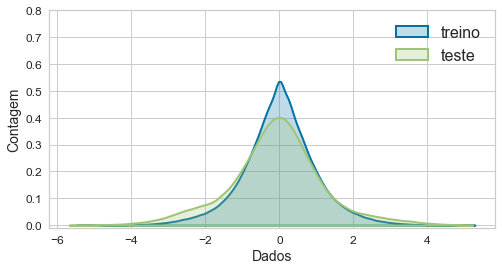

In [25]:
plt.figure(figsize=(8,4))
sns.distplot(X_train_scaled, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                  label = 'treino')
sns.distplot(X_test_scaled, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                  label = 'teste')
plt.xlabel("Dados", size=14)
plt.ylabel("Contagem", size=14)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
#plt.title("Dados treino x teste (X)")
plt.ylim([-0.01,0.8])

plt.legend(loc='upper right',fontsize=16)

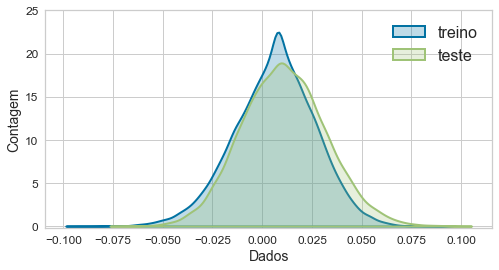

In [26]:
plt.figure(figsize=(8,4))
sns.distplot(y_train, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                  label = 'treino')
sns.distplot(y_test, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                  label = 'teste')
plt.xlabel("Dados", size=14)
plt.ylabel("Contagem", size=14)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.ylim([-0.2,25])
plt.legend(loc='upper right',fontsize=16)

A distribuição parece ser representativa, podemos seguir em frente

In [5]:
from yellowbrick.model_selection import FeatureImportances
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import numpy as np
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error
from yellowbrick.model_selection import learning_curve
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from yellowbrick.model_selection import feature_importances
import xgboost as xgb
from sklearn.linear_model import ElasticNet
import eli5
from tqdm import tqdm
from eli5.sklearn import PermutationImportance



def summary_plot(model,X_train,y_train,X_test,y_test,cv,train_sizes=np.linspace(0.1,1.0,5),lc=False):

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))
    plt.rc('legend',fontsize=12.5) 


    visualize_residuals = residuals_plot(model,X_train, y_train, X_test, y_test,show=False,ax=ax[0],title=' ');
    ax[0].tick_params(labelsize=13)
    ax[0].set_xlabel('Predicted value (mm)',fontsize=16)
    ax[0].set_ylabel('Residuals (mm)',fontsize=16)

    visualizer = prediction_error(model, X_test, y_test, show=False, ax=ax[1], title=' ')
    ax[1].tick_params(labelsize=13)
    ax[1].set_xlabel('Predicted value (mm)',fontsize=16)
    ax[1].set_ylabel('Real value (mm)',fontsize=16)

    if lc:
        print('Plotting learning curves')
        visual_LC = learning_curve(model, X_train, y_train,scoring='r2',cv=cv,ax=ax[2],title=' ',show=False,train_sizes=train_sizes,n_jobs=-1);
        ax[2].set_ylim([0.6, 1.05])
        ax[2].tick_params(labelsize=13)
        ax[2].set_xlabel('Number of training instances',fontsize=16)
        ax[2].set_ylabel(r'$R^2$' + ' metric',fontsize=16)
        
    plt.show()
    
    return


def metrics(y_test,predict):
    
    mse = mean_squared_error(y_test,predict)
    mae= mean_absolute_error(y_test,predict)
    r2= r2_score(y_test,predict)
    return print("MSE:{}".format(mse),"\nMAE:{}".format(mae),"\nR2:{}".format(r2))


def feature_importance(X_train,y_train,X_test,y_test,relative=True,topn=9):
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 10),sharex=True)
    plt.rc('legend',fontsize=12.5) 

    ################################################################
    # Lasso Regression
    ################################################################
    
    mod = Lasso(alpha=0.001)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    viz1 = FeatureImportances(Lasso(alpha=0.001),relative=relative,topn=topn, title =' ',ax=ax[0,0],absolute=True)
    viz1.fit(X_train,y_train)
    ax[0,0].tick_params(labelsize=13)
    ax[0,0].set_title('Lasso Regression - R^2 = {}'.format(r2),fontsize=20)

    ################################################################

    mod = RandomForestRegressor(**study_rf.best_params,random_state=2020)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    rfr = RandomForestRegressor(**study_rf.best_params,random_state=2020)
    viz2 = FeatureImportances(rfr,relative=relative, topn=topn, title =' ',ax=ax[0,1])
    viz2.fit(X_train,y_train)
    ax[0,1].tick_params(labelsize=13)
    ax[0,1].set_title('RandomForestRegressor - R^2 = {}'.format(r2),fontsize=20)
    
    ################################################################

    mod = xgb.XGBRegressor(**study_xgb.best_params,random_state=2020)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    abr = xgb.XGBRegressor(**study_xgb.best_params,random_state=2020)
    viz3 = FeatureImportances(abr,relative=relative, topn=topn, title =' ', ax=ax[1,0])
    viz3.fit(X_train,y_train)
    ax[1,0].tick_params(labelsize=13)
    ax[1,0].set_xlabel('Relative feature importance',fontsize=16)
    ax[1,0].set_title('XGBoostRegressor - R^2 = {}'.format(r2),fontsize=20)
  
    ################################################################
    
    mod = ElasticNet(**study_en.best_params,random_state=2020)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    gbr = ElasticNet(**study_en.best_params,random_state=2020)
    viz4 = FeatureImportances(gbr,relative=relative, topn=topn, title =' ',ax=ax[1,1])
    viz4.fit(X_train,y_train)
    ax[1,1].tick_params(labelsize=13)
    ax[1,1].set_xlabel('Relative feature importance',fontsize=16)
    ax[1,1].set_title('ElasticNet - R^2 = {}'.format(r2),fontsize=20)

    plt.tight_layout()
    plt.show()
    
    return


class multivariate_importance():
    def __init__(self, X_train, X_test, y_train, y_test, nmodels=6):

        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.nmodels = nmodels

        mod1 = Lasso(alpha=0.001)
        mod2 = RandomForestRegressor(**study_rf.best_params,random_state=2020)
        mod3 = xgb.XGBRegressor(**study_xgb.best_params,random_state=2020)
        mod4 = GradientBoostingRegressor(**study_rf.best_params,random_state=2020)
        mod5 = ExtraTreesRegressor(**study_et.best_params,random_state=2020, n_jobs=-1)
        mod6 = ElasticNet(**study_en.best_params,random_state=2020)

        self.mod_list = [mod1, mod2,
                         mod3, mod4,
                         mod5, mod6]

        self.mod_list = self.mod_list[0:self.nmodels]

        self.model_r2 = None

        print('All models for determining feature importance')
        print(self.mod_list)
        print('')

    def train_models(self):

        model_r2 = []
        for model in tqdm(self.mod_list):
            model.fit(self.X_train, self.y_train)
            model_r2.append(np.round(r2_score(self.y_test, model.predict(self.X_test)), 4))

        self.model_r2 = model_r2

        return model_r2

    def permutation_importance(self, model_index=1):

        self.mod_list[model_index].fit(self.X_train, self.y_train)
        perm = PermutationImportance(self.mod_list[model_index], random_state=1).fit(
            self.X_train, self.y_train)
        return eli5.show_weights(perm, feature_names=X_train.columns.tolist())

    def plot(self, relative=True, topn=9, absolute=True, plot_R2=True):

        fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30, 18))

        if self.model_r2 == None:
            print('Obtaining R2 score for all 6 models')
            multivariate_importance.train_models(self)
            print('R2 score calculated')

        print('Obtaining feature importance - 0%')
        viz1 = FeatureImportances(self.mod_list[0], relative=relative, topn=topn, ax=ax[0, 0], absolute=absolute)
        viz1.fit(self.X_train, self.y_train)
        ax[0, 0].tick_params(labelsize=16)

        viz2 = FeatureImportances(self.mod_list[1], relative=relative, topn=topn, ax=ax[0, 1], absolute=absolute)
        viz2.fit(self.X_train, self.y_train)
        ax[0, 1].tick_params(labelsize=16)

        viz3 = FeatureImportances(self.mod_list[2], relative=relative, topn=topn, ax=ax[0, 2], absolute=absolute)
        viz3.fit(self.X_train, self.y_train)
        ax[0, 2].tick_params(labelsize=18)
        print('Obtaining feature importance - 50%')
        viz4 = FeatureImportances(self.mod_list[3], relative=relative, topn=topn, ax=ax[1, 0], absolute=absolute)
        viz4.fit(self.X_train, self.y_train)
        ax[1, 0].tick_params(labelsize=18)

        viz5 = FeatureImportances(self.mod_list[4], relative=relative, topn=topn, ax=ax[1, 1], absolute=absolute)
        viz5.fit(self.X_train, self.y_train)
        ax[1, 1].tick_params(labelsize=18)

        viz6 = FeatureImportances(self.mod_list[5], relative=relative, topn=topn, ax=ax[1, 2], absolute=absolute)
        viz6.fit(self.X_train, self.y_train)
        ax[1, 2].tick_params(labelsize=18)
        print('Obtaining feature importance - 100%')

        if plot_R2:

            ax[0, 0].set_title(
                'Lasso Regression - $R^2$ = {}'.format(self.model_r2[0]), fontsize=25)
            ax[0, 1].set_title(
                'RandomForestRegressor - $R^2$ = {}'.format(self.model_r2[1]), fontsize=25)
            ax[0, 2].set_title(
                'XGBoostRegressor - $R^2$ = {}'.format(self.model_r2[2]), fontsize=25)
            ax[1, 0].set_title(
                'GradientBoostingRegressor - $R^2$ = {}'.format(self.model_r2[3]), fontsize=25)
            ax[1, 1].set_title(
                'ExtraTreesRegressor - $R^2$ = {}'.format(self.model_r2[4]), fontsize=25)
            ax[1, 2].set_title(
                'ElasticNet - $R^2$ = {}'.format(self.model_r2[5]), fontsize=25)

            ax[0, 0].set_xlabel('Coefficient value', fontsize=24)
            ax[0, 1].set_xlabel('Coefficient value', fontsize=24)
            ax[0, 2].set_xlabel('Coefficient value', fontsize=24)
            ax[1, 0].set_xlabel('Coefficient value', fontsize=24)
            ax[1, 1].set_xlabel('Coefficient value', fontsize=24)
            ax[1, 2].set_xlabel('Coefficient value', fontsize=24)
            ax[0, 0].set_xlim([0,0.1])
            #ax[0, 1].set_xlim([0,0.5])
            #ax[0, 2].set_xlim([0,0.5])
            #ax[1, 0].set_xlim([0,0.5])
            #ax[1, 1].set_xlim([0,0.5])
            ax[1, 2].set_xlim([0,0.1])

        plt.tight_layout()
        return


In [6]:
study_rf = joblib.load("study_RandomForest_FR_FRA6.pkl")
study_ab = joblib.load("study_AdaBost.pkl")
study_en = joblib.load("study_ElasticNet_FR_FRA6.pkl")
study_xgb = joblib.load("study_XGBoost.pkl")
study_et = joblib.load("study_Extratrees.pkl")


In [9]:
jalkkhkjhsfkhlajjç

NameError: name 'jalkkhkjhsfkhlajjç' is not defined

All models for determining feature importance
[Lasso(alpha=0.001), RandomForestRegressor(max_depth=12, max_features=7, min_samples_leaf=2,
                      min_samples_split=4, n_estimators=525, random_state=2020), XGBRegressor(alpha=0.02111400159780091, base_score=None, booster=None,
             colsample_bylevel=0.9000000000000001, colsample_bynode=1.0,
             colsample_bytree=0.6000000000000001, enable_categorical=False,
             gamma=None, gpu_id=None, importance_type=None,
             interaction_constraints=None, lambda=0.001530808845481313,
             learning_rate=None, max_delta_step=None, max_depth=10,
             min_child_weight=7.1, min_split_loss=0.0027632330369892592,
             missing=nan, monotone_constraints=None, n_estimators=5850,
             n_jobs=None, num_parallel_tree=None, predictor=None,
             random_state=2020, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=0.7000000000000001,
             tree_

  0%|          | 0/6 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Temp\ipykernel_11924\1172260965.py:150: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(self.X_train, self.y_train)
 33%|███▎      | 2/6 [02:11<04:22, 65.75s/it]c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 50%|█████     | 3/6 [08:08<09:20, 186.99s/it]c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 67%|██████▋   | 4/6 [12:09<06:54, 2

R2 score calculated
Obtaining feature importance - 0%
Obtaining feature importance - 50%


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(


Obtaining feature importance - 100%
CPU times: total: 26min
Wall time: 12min 22s


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

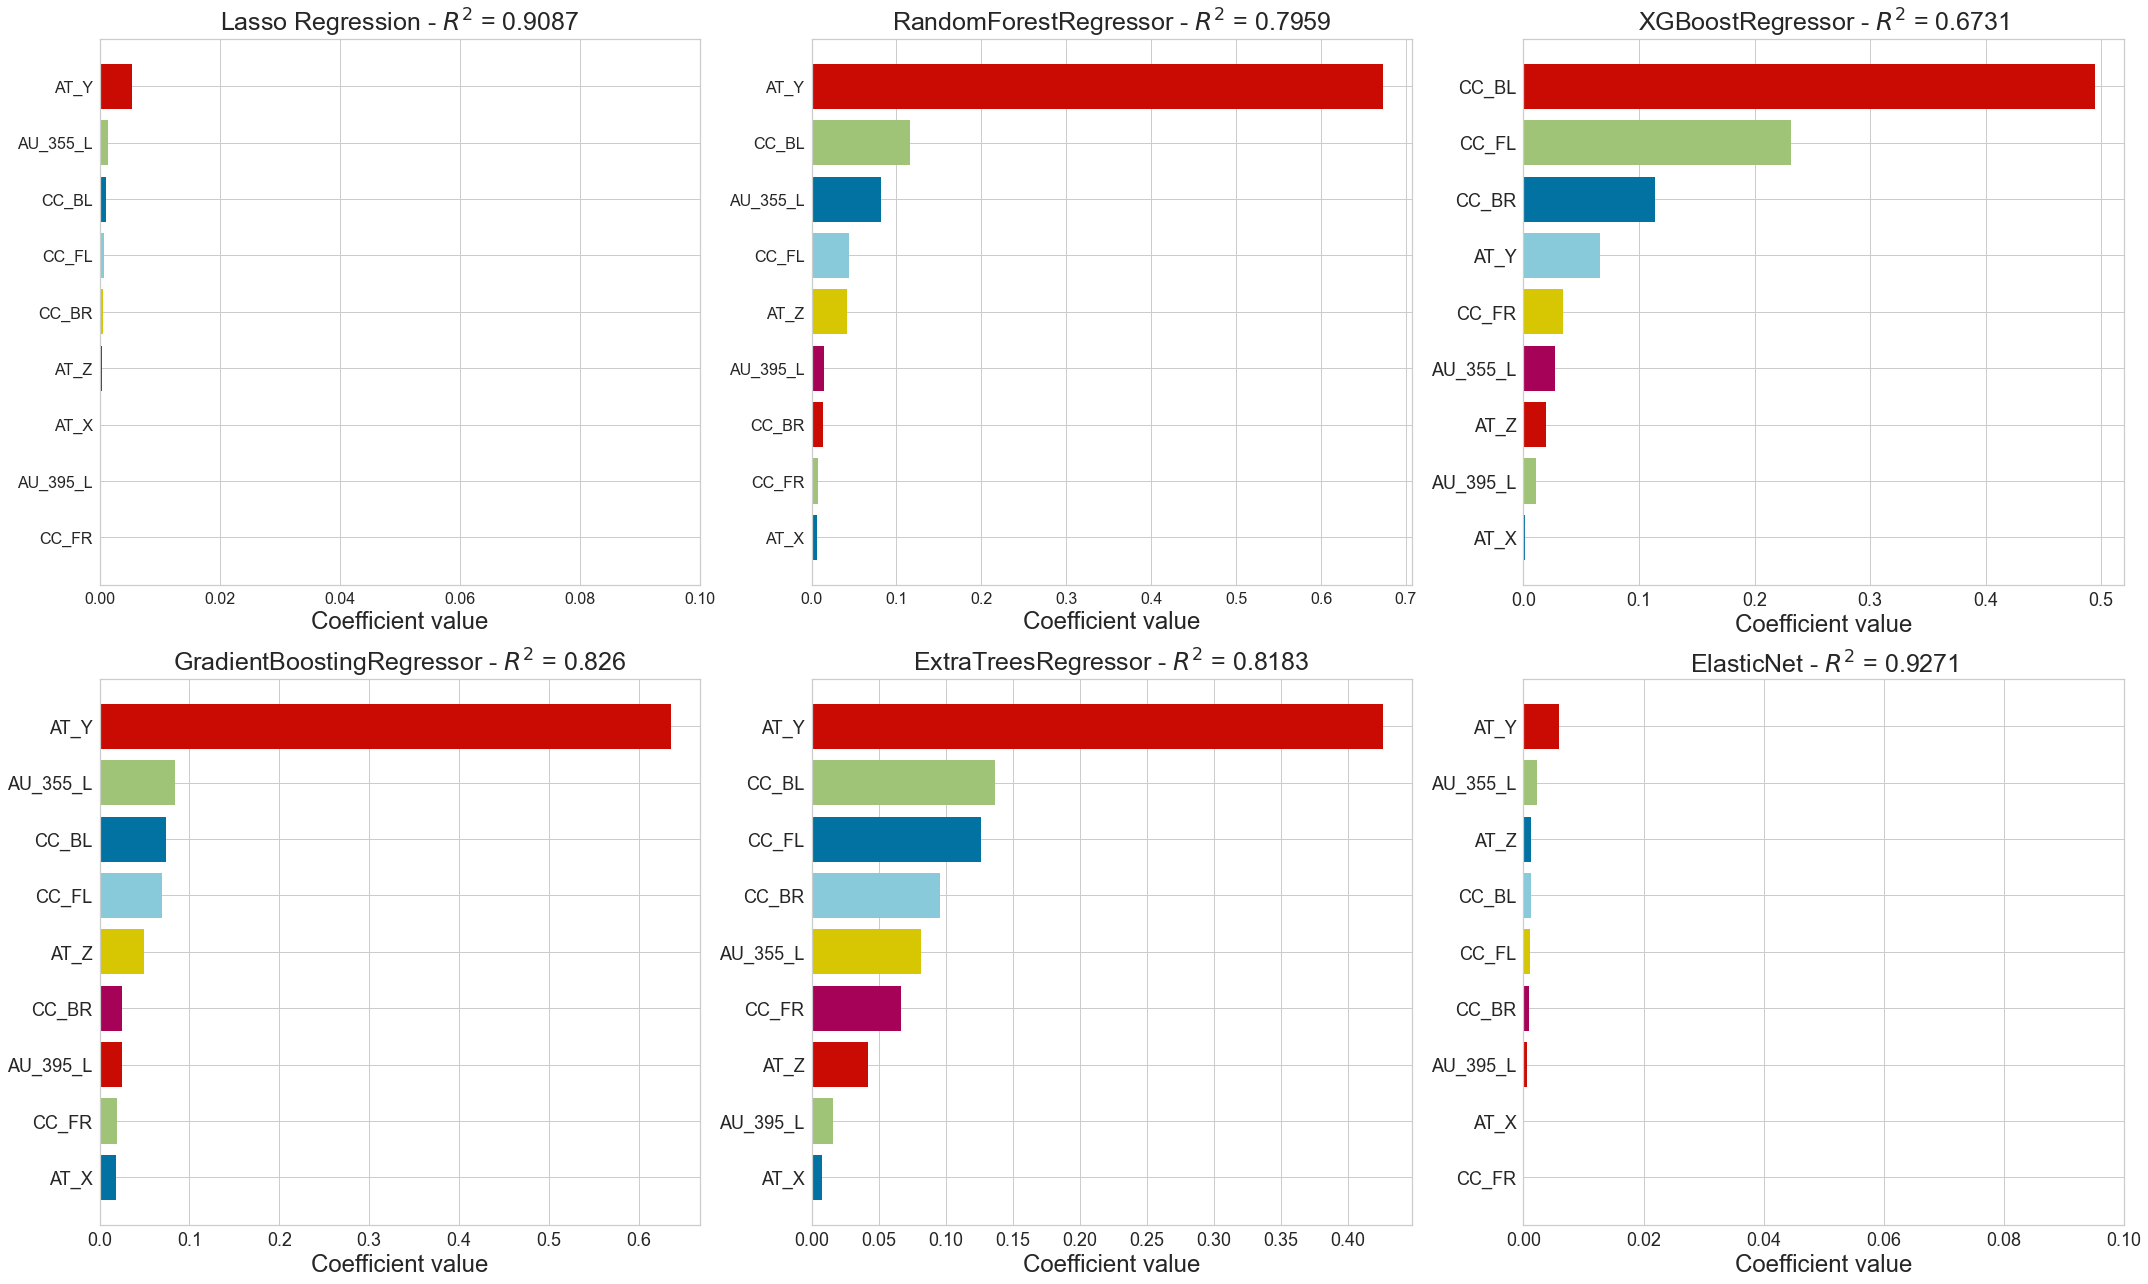

In [7]:
%%time
multi_select = multivariate_importance(X_train_scaled,X_test_scaled,y_train,y_test)     
multi_select.plot(relative=False)
import warnings # Ignore alert messages
warnings.simplefilter(action='ignore', category=FutureWarning)

np.seterr(divide='ignore')

# Optuna study

In [ ]:
#X, y = df_nadal[['CC_FR', 'CC_FL', 'CC_BR', 'CC_BL','AT_Y',
#'AU_395_FR','AU_395_FL','AU_275_FR','AU_275_FL']], df_nadal[['L/V_FR']]
#X_train_scaled,X_test_scaled,y_train,y_test = create_scaled_dataset(X,y)

### Random Forest - FR

In [12]:
import optuna

def objective(trial):
    
    joblib.dump(study, 'study.pkl')
    
    f_n_estimators = trial.suggest_int("n_estimators", low=200,high=1000,step=25)
    f_max_depth = trial.suggest_int("max_depth", low=2,high=50,step=2)
    f_min_samples_leaf = trial.suggest_int("min_samples_leaf", low=1, high=20, step=1)
    f_min_samples_split = trial.suggest_int("min_samples_split", low=2, high=20, step=1)
    int_max_features = np.arange(2,len(X_train_scaled.columns),1,dtype=int) 
    max_features_list = []
    for e in int_max_features: 
       max_features_list.append(int(e))
    f_max_features = trial.suggest_categorical("max_features",max_features_list) 
     
    model = RandomForestRegressor(max_depth=f_max_depth,
                                           n_estimators = f_n_estimators,
                                           min_samples_split = f_min_samples_split,
                                           min_samples_leaf = f_min_samples_leaf,
                                           max_features = f_max_features,
                                           random_state=0, 
                                           n_jobs = -1)
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
study = optuna.create_study(direction='maximize')

[I 2022-12-09 12:17:54,919] A new study created in memory with name: no-name-8727386c-7a28-402d-9b9a-30ba829a64f3


In [13]:
study.optimize(objective, n_trials=50,show_progress_bar=True)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:18:35,744] Trial 0 finished with value: 0.8019374821142056 and parameters: {'n_estimators': 300, 'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 8, 'max_features': 5}. Best is trial 0 with value: 0.8019374821142056.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:19:28,666] Trial 1 finished with value: 0.8021745215316305 and parameters: {'n_estimators': 675, 'max_depth': 34, 'min_samples_leaf': 9, 'min_samples_split': 18, 'max_features': 5}. Best is trial 1 with value: 0.8021745215316305.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:19:57,455] Trial 2 finished with value: 0.8058649651262927 and parameters: {'n_estimators': 250, 'max_depth': 16, 'min_samples_leaf': 14, 'min_samples_split': 7, 'max_features': 8}. Best is trial 2 with value: 0.8058649651262927.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:20:35,534] Trial 3 finished with value: 0.8037900465116409 and parameters: {'n_estimators': 375, 'max_depth': 28, 'min_samples_leaf': 5, 'min_samples_split': 15, 'max_features': 6}. Best is trial 2 with value: 0.8058649651262927.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:21:38,325] Trial 4 finished with value: 0.8012369179861379 and parameters: {'n_estimators': 800, 'max_depth': 8, 'min_samples_leaf': 19, 'min_samples_split': 16, 'max_features': 8}. Best is trial 2 with value: 0.8058649651262927.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:22:22,744] Trial 5 finished with value: 0.7773689507233282 and parameters: {'n_estimators': 950, 'max_depth': 20, 'min_samples_leaf': 19, 'min_samples_split': 11, 'max_features': 3}. Best is trial 2 with value: 0.8058649651262927.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:23:51,520] Trial 6 finished with value: 0.8025973268491088 and parameters: {'n_estimators': 975, 'max_depth': 20, 'min_samples_leaf': 12, 'min_samples_split': 10, 'max_features': 6}. Best is trial 2 with value: 0.8058649651262927.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:24:24,270] Trial 7 finished with value: 0.8074776603090736 and parameters: {'n_estimators': 250, 'max_depth': 24, 'min_samples_leaf': 2, 'min_samples_split': 3, 'max_features': 7}. Best is trial 7 with value: 0.8074776603090736.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:24:57,561] Trial 8 finished with value: 0.8057202151285705 and parameters: {'n_estimators': 300, 'max_depth': 14, 'min_samples_leaf': 12, 'min_samples_split': 15, 'max_features': 8}. Best is trial 7 with value: 0.8074776603090736.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:25:45,477] Trial 9 finished with value: 0.8002290007036692 and parameters: {'n_estimators': 625, 'max_depth': 28, 'min_samples_leaf': 13, 'min_samples_split': 17, 'max_features': 5}. Best is trial 7 with value: 0.8074776603090736.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:27:00,521] Trial 10 finished with value: 0.8052740549527139 and parameters: {'n_estimators': 475, 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 3, 'max_features': 7}. Best is trial 7 with value: 0.8074776603090736.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:27:09,768] Trial 11 finished with value: 0.6227449122057206 and parameters: {'n_estimators': 225, 'max_depth': 4, 'min_samples_leaf': 15, 'min_samples_split': 3, 'max_features': 7}. Best is trial 7 with value: 0.8074776603090736.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:27:28,140] Trial 12 finished with value: 0.7620327520848026 and parameters: {'n_estimators': 450, 'max_depth': 38, 'min_samples_leaf': 8, 'min_samples_split': 6, 'max_features': 2}. Best is trial 7 with value: 0.8074776603090736.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:27:39,917] Trial 13 finished with value: 0.7892115583397517 and parameters: {'n_estimators': 200, 'max_depth': 12, 'min_samples_leaf': 16, 'min_samples_split': 6, 'max_features': 4}. Best is trial 7 with value: 0.8074776603090736.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:29:07,786] Trial 14 finished with value: 0.8075331691248306 and parameters: {'n_estimators': 500, 'max_depth': 42, 'min_samples_leaf': 1, 'min_samples_split': 2, 'max_features': 8}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:30:27,448] Trial 15 finished with value: 0.8056878725532631 and parameters: {'n_estimators': 500, 'max_depth': 48, 'min_samples_leaf': 1, 'min_samples_split': 2, 'max_features': 7}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:31:13,940] Trial 16 finished with value: 0.7913350436171012 and parameters: {'n_estimators': 750, 'max_depth': 40, 'min_samples_leaf': 5, 'min_samples_split': 4, 'max_features': 3}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:31:37,139] Trial 17 finished with value: 0.768486622774591 and parameters: {'n_estimators': 550, 'max_depth': 34, 'min_samples_leaf': 3, 'min_samples_split': 20, 'max_features': 2}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:32:05,160] Trial 18 finished with value: 0.7977848589590035 and parameters: {'n_estimators': 400, 'max_depth': 44, 'min_samples_leaf': 7, 'min_samples_split': 12, 'max_features': 4}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:33:01,077] Trial 19 finished with value: 0.8060697068512659 and parameters: {'n_estimators': 325, 'max_depth': 32, 'min_samples_leaf': 3, 'min_samples_split': 5, 'max_features': 8}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:34:59,593] Trial 20 finished with value: 0.8067453985807459 and parameters: {'n_estimators': 850, 'max_depth': 24, 'min_samples_leaf': 3, 'min_samples_split': 9, 'max_features': 7}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:37:05,867] Trial 21 finished with value: 0.8066381893717501 and parameters: {'n_estimators': 850, 'max_depth': 24, 'min_samples_leaf': 3, 'min_samples_split': 2, 'max_features': 7}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:38:47,865] Trial 22 finished with value: 0.8061888136876254 and parameters: {'n_estimators': 700, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 8, 'max_features': 7}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:40:02,964] Trial 23 finished with value: 0.8065283598204309 and parameters: {'n_estimators': 600, 'max_depth': 22, 'min_samples_leaf': 3, 'min_samples_split': 4, 'max_features': 7}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:41:48,739] Trial 24 finished with value: 0.8060744912052696 and parameters: {'n_estimators': 875, 'max_depth': 38, 'min_samples_leaf': 6, 'min_samples_split': 13, 'max_features': 7}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:42:58,225] Trial 25 finished with value: 0.8063224078800748 and parameters: {'n_estimators': 550, 'max_depth': 26, 'min_samples_leaf': 10, 'min_samples_split': 9, 'max_features': 8}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:43:54,319] Trial 26 finished with value: 0.8050568530550313 and parameters: {'n_estimators': 425, 'max_depth': 44, 'min_samples_leaf': 2, 'min_samples_split': 5, 'max_features': 7}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:44:59,315] Trial 27 finished with value: 0.7992879388839863 and parameters: {'n_estimators': 900, 'max_depth': 16, 'min_samples_leaf': 4, 'min_samples_split': 2, 'max_features': 4}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:45:32,187] Trial 28 finished with value: 0.7613160137695267 and parameters: {'n_estimators': 750, 'max_depth': 24, 'min_samples_leaf': 6, 'min_samples_split': 7, 'max_features': 2}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:45:58,373] Trial 29 finished with value: 0.7935568077611715 and parameters: {'n_estimators': 350, 'max_depth': 34, 'min_samples_leaf': 4, 'min_samples_split': 8, 'max_features': 3}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:46:36,296] Trial 30 finished with value: 0.8036644593424266 and parameters: {'n_estimators': 275, 'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 4, 'max_features': 6}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:48:50,054] Trial 31 finished with value: 0.8067932809927512 and parameters: {'n_estimators': 875, 'max_depth': 24, 'min_samples_leaf': 2, 'min_samples_split': 2, 'max_features': 7}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:50:48,703] Trial 32 finished with value: 0.8060701175554359 and parameters: {'n_estimators': 800, 'max_depth': 24, 'min_samples_leaf': 1, 'min_samples_split': 3, 'max_features': 7}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:52:26,747] Trial 33 finished with value: 0.8019310498810466 and parameters: {'n_estimators': 1000, 'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 2, 'max_features': 5}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:53:35,571] Trial 34 finished with value: 0.8088443068300946 and parameters: {'n_estimators': 675, 'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 5, 'max_features': 7}. Best is trial 34 with value: 0.8088443068300946.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:54:23,118] Trial 35 finished with value: 0.7761585919803281 and parameters: {'n_estimators': 675, 'max_depth': 6, 'min_samples_leaf': 6, 'min_samples_split': 5, 'max_features': 8}. Best is trial 34 with value: 0.8088443068300946.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:55:22,819] Trial 36 finished with value: 0.8099171028675878 and parameters: {'n_estimators': 525, 'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 4, 'max_features': 7}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:56:22,452] Trial 37 finished with value: 0.807720623398656 and parameters: {'n_estimators': 575, 'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 6, 'max_features': 8}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:57:15,643] Trial 38 finished with value: 0.8045149378416766 and parameters: {'n_estimators': 550, 'max_depth': 8, 'min_samples_leaf': 9, 'min_samples_split': 6, 'max_features': 8}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:57:33,734] Trial 39 finished with value: 0.43491515096113353 and parameters: {'n_estimators': 625, 'max_depth': 2, 'min_samples_leaf': 8, 'min_samples_split': 7, 'max_features': 8}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:58:30,399] Trial 40 finished with value: 0.8059090311304014 and parameters: {'n_estimators': 500, 'max_depth': 12, 'min_samples_leaf': 17, 'min_samples_split': 4, 'max_features': 8}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:59:17,438] Trial 41 finished with value: 0.80390471125803 and parameters: {'n_estimators': 600, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 3, 'max_features': 6}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 13:00:22,608] Trial 42 finished with value: 0.8036795327183375 and parameters: {'n_estimators': 650, 'max_depth': 16, 'min_samples_leaf': 2, 'min_samples_split': 5, 'max_features': 5}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 13:01:23,475] Trial 43 finished with value: 0.8066804849229772 and parameters: {'n_estimators': 725, 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 3, 'max_features': 8}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 13:02:15,575] Trial 44 finished with value: 0.8074987020525253 and parameters: {'n_estimators': 525, 'max_depth': 12, 'min_samples_leaf': 4, 'min_samples_split': 6, 'max_features': 7}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 13:03:19,154] Trial 45 finished with value: 0.8080657003556342 and parameters: {'n_estimators': 525, 'max_depth': 14, 'min_samples_leaf': 4, 'min_samples_split': 7, 'max_features': 8}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 13:04:17,534] Trial 46 finished with value: 0.8055836725632473 and parameters: {'n_estimators': 450, 'max_depth': 18, 'min_samples_leaf': 12, 'min_samples_split': 8, 'max_features': 8}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 13:05:30,365] Trial 47 finished with value: 0.8074135848107116 and parameters: {'n_estimators': 575, 'max_depth': 14, 'min_samples_leaf': 7, 'min_samples_split': 7, 'max_features': 8}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 13:06:02,667] Trial 48 finished with value: 0.7752492891169203 and parameters: {'n_estimators': 475, 'max_depth': 6, 'min_samples_leaf': 11, 'min_samples_split': 11, 'max_features': 8}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 13:06:10,861] Trial 49 finished with value: 0.2354682880688329 and parameters: {'n_estimators': 650, 'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 4, 'max_features': 3}. Best is trial 36 with value: 0.8099171028675878.
Accuracy: 0.8099171028675878
Best hyperparameters: {'n_estimators': 525, 'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 4, 'max_features': 7}


In [14]:
joblib.dump(study, "study_RandomForest_FR_FRA6.pkl")

['study_RandomForest_FR_FRA6.pkl']

In [15]:
study.best_trial

FrozenTrial(number=36, values=[0.8099171028675878], datetime_start=datetime.datetime(2022, 12, 9, 12, 54, 23, 127016), datetime_complete=datetime.datetime(2022, 12, 9, 12, 55, 22, 819444), params={'n_estimators': 525, 'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 4, 'max_features': 7}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=200, step=25), 'max_depth': IntDistribution(high=50, log=False, low=2, step=2), 'min_samples_leaf': IntDistribution(high=20, log=False, low=1, step=1), 'min_samples_split': IntDistribution(high=20, log=False, low=2, step=1), 'max_features': CategoricalDistribution(choices=(2, 3, 4, 5, 6, 7, 8))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=36, state=TrialState.COMPLETE, value=None)

In [16]:
optuna.visualization.plot_optimization_history(study)

In [17]:
optuna.visualization.plot_slice(study)

### Extra-Trees Regressor

In [18]:
from sklearn.ensemble import ExtraTreesRegressor

def objective(trial):
    
        
    param = {
        'n_estimators': trial.suggest_int('n_estimators',200,800,25),
        'max_depth': trial.suggest_int('max_depth',2,20,2),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf',1,10,1),
        'random_state': 2020,
        #'max_leaf_nodes': trial.suggest_int('max_leaf_nodes',1,1000,25),
       
        'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf',0.0,0.2,step=0.01),
    
    }
    
    model = ExtraTreesRegressor(**param)    
  
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
study_ext = optuna.create_study(direction='maximize')

[I 2022-12-09 13:10:20,659] A new study created in memory with name: no-name-f2fea36f-3ed4-4d42-a7f6-5b187bed0983


In [19]:
study_ext.optimize(objective, n_trials=100,show_progress_bar=True)

trial_ext = study_ext.best_trial

print('Accuracy: {}'.format(trial_ext.value))
print("Best hyperparameters: {}".format(trial_ext.params))

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-09 13:10:33,199] Trial 0 finished with value: 0.399219684623596 and parameters: {'n_estimators': 800, 'max_depth': 4, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.04}. Best is trial 0 with value: 0.399219684623596.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-09 13:10:36,923] Trial 1 finished with value: 0.19446238131446758 and parameters: {'n_estimators': 525, 'max_depth': 4, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.12}. Best is trial 0 with value: 0.399219684623596.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-09 13:10:40,180] Trial 2 finished with value: 0.2108751867458778 and parameters: {'n_estimators': 525, 'max_depth': 2, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.11}. Best is trial 0 with value: 0.399219684623596.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-09 13:10:42,841] Trial 3 finished with value: 0.21505165187199526 and parameters: {'n_estimators': 425, 'max_depth': 6, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.11}. Best is trial 0 with value: 0.399219684623596.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[W 2022-12-09 13:10:45,084] Trial 4 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\283992923.py", line 19, in objective
    model.fit(X_train_scaled,y_train)
  File "c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\joblib\parallel.py", line 1088, in __call__
    while self.dispatch_one_batch(iterator):
  File "c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\joblib\parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\joblib\parallel.py", line 819, in _dispatch
    job = self._backend.apply_async(batch

KeyboardInterrupt: 

In [ ]:
joblib.dump(study_ext, "study_ExtraTrees.pkl")

['study_ExtraTrees.pkl']

In [ ]:
optuna.visualization.plot_optimization_history(study_ext)

In [ ]:
optuna.visualization.plot_slice(study_ext)

### ElasticNet

In [5]:
from sklearn.linear_model import ElasticNet

def objective(trial):
    
        
    h_alpha = trial.suggest_float("alpha", low=0.0001, high=1, step=0.0001)
    h_l1_ratio= trial.suggest_float("l1_ratio", low=0.0, high=0.5,step=0.01)
    
    h_selection = trial.suggest_categorical("selection", ['cyclic','random'])
    
    model = ElasticNet(alpha=h_alpha,l1_ratio=h_l1_ratio,
                                       
                                       selection=h_selection,
                                       random_state=0)
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
study_en = optuna.create_study(direction='maximize')

[I 2022-12-09 14:33:30,948] A new study created in memory with name: no-name-d89b28a2-844c-400a-9a3d-db3877b71383


In [6]:
study_en.optimize(objective, n_trials=500,show_progress_bar=True)

trial_en = study_en.best_trial

print('Accuracy: {}'.format(trial_en.value))
print("Best hyperparameters: {}".format(trial_en.params))

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2022-12-09 14:33:36,830] Trial 0 finished with value: -0.3369294516240158 and parameters: {'alpha': 0.3075, 'l1_ratio': 0.38, 'selection': 'cyclic'}. Best is trial 0 with value: -0.3369294516240158.
[I 2022-12-09 14:33:36,853] Trial 1 finished with value: -0.3369294516240158 and parameters: {'alpha': 0.14429999999999998, 'l1_ratio': 0.31, 'selection': 'random'}. Best is trial 0 with value: -0.3369294516240158.
[I 2022-12-09 14:33:36,869] Trial 2 finished with value: -0.3369294516240158 and parameters: {'alpha': 0.8072, 'l1_ratio': 0.42, 'selection': 'cyclic'}. Best is trial 0 with value: -0.3369294516240158.
[I 2022-12-09 14:33:36,888] Trial 3 finished with value: -0.3369294516240158 and parameters: {'alpha': 0.7282000000000001, 'l1_ratio': 0.08, 'selection': 'cyclic'}. Best is trial 0 with value: -0.3369294516240158.
[I 2022-12-09 14:33:36,911] Trial 4 finished with value: -0.3369294516240158 and parameters: {'alpha': 0.7674, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.605e-01, tolerance: 5.995e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:33:39,297] Trial 29 finished with value: 0.8806021850849034 and parameters: {'alpha': 0.0941, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 28 with value: 0.8874531438921972.
[I 2022-12-09 14:33:39,348] Trial 30 finished with value: 0.4679721593216738 and parameters: {'alpha': 0.3859, 'l1_ratio': 0.01, 'selection': 'random'}. Best is trial 28 with value: 0.8874531438921972.
[I 2022-12-09 14:33:39,400] Trial 31 finished with value: 0.402900855414123 and parameters: {'alpha': 0.0956, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 28 with value: 0.8874531438921972.
[I 2022-12-09 14:33:39,438] Trial 32 finished with value: -0.3369294516240158 and parameters: {'alpha': 0.1945, 'l1_ratio': 0.13, 'selection': 'random'}. Best is trial 28 with value: 0.8874531438921972.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.419e-01, tolerance: 5.995e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:33:40,367] Trial 33 finished with value: 0.8820817773584662 and parameters: {'alpha': 0.0791, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 28 with value: 0.8874531438921972.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.597e-01, tolerance: 5.995e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:33:41,765] Trial 34 finished with value: 0.8806627404615015 and parameters: {'alpha': 0.09350000000000001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 28 with value: 0.8874531438921972.
[I 2022-12-09 14:33:41,797] Trial 35 finished with value: -0.300304797959732 and parameters: {'alpha': 0.1541, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 28 with value: 0.8874531438921972.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.412e-01, tolerance: 5.995e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:33:42,990] Trial 36 finished with value: 0.861216751337109 and parameters: {'alpha': 0.2658, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 28 with value: 0.8874531438921972.
[I 2022-12-09 14:33:43,137] Trial 37 finished with value: 0.6746038751781281 and parameters: {'alpha': 0.06970000000000001, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 28 with value: 0.8874531438921972.
[I 2022-12-09 14:33:43,372] Trial 38 finished with value: -0.3369294516240158 and parameters: {'alpha': 0.1429, 'l1_ratio': 0.11, 'selection': 'random'}. Best is trial 28 with value: 0.8874531438921972.
[I 2022-12-09 14:33:43,423] Trial 39 finished with value: -0.3369294516240158 and parameters: {'alpha': 0.993, 'l1_ratio': 0.07, 'selection': 'random'}. Best is trial 28 with value: 0.8874531438921972.
[I 2022-12-09 14:33:43,459] Trial 40 finished with value: -0.3369294516240158 and parameters: {'alpha': 0.6245, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 28 with valu

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.673e-01, tolerance: 5.995e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:33:44,139] Trial 41 finished with value: 0.8800322833158928 and parameters: {'alpha': 0.09970000000000001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 28 with value: 0.8874531438921972.
[I 2022-12-09 14:33:44,218] Trial 42 finished with value: 0.776481158178126 and parameters: {'alpha': 0.058600000000000006, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 28 with value: 0.8874531438921972.
[I 2022-12-09 14:33:44,266] Trial 43 finished with value: 0.4176387794559502 and parameters: {'alpha': 0.06760000000000001, 'l1_ratio': 0.07, 'selection': 'random'}. Best is trial 28 with value: 0.8874531438921972.
[I 2022-12-09 14:33:44,320] Trial 44 finished with value: 0.5576043670591719 and parameters: {'alpha': 0.12200000000000001, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 28 with value: 0.8874531438921972.
[I 2022-12-09 14:33:44,355] Trial 45 finished with value: -0.3369294516240158 and parameters: {'alpha': 0.2823, 'l1_ratio': 0.11, 'selection'

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.747e-01, tolerance: 5.995e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:33:45,154] Trial 46 finished with value: 0.8693093883753165 and parameters: {'alpha': 0.197, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 28 with value: 0.8874531438921972.
[I 2022-12-09 14:33:45,197] Trial 47 finished with value: 0.7223461928541275 and parameters: {'alpha': 0.047700000000000006, 'l1_ratio': 0.05, 'selection': 'cyclic'}. Best is trial 28 with value: 0.8874531438921972.
[I 2022-12-09 14:33:45,231] Trial 48 finished with value: -0.3369294516240158 and parameters: {'alpha': 0.3479, 'l1_ratio': 0.34, 'selection': 'random'}. Best is trial 28 with value: 0.8874531438921972.
[I 2022-12-09 14:33:45,274] Trial 49 finished with value: 0.6972896751364506 and parameters: {'alpha': 0.12250000000000001, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 28 with value: 0.8874531438921972.
[I 2022-12-09 14:33:45,318] Trial 50 finished with value: -0.3369294516240158 and parameters: {'alpha': 0.183, 'l1_ratio': 0.09, 'selection': 'cyclic'}. Best is trial

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.545e-01, tolerance: 5.995e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:33:45,920] Trial 51 finished with value: 0.8810936339557148 and parameters: {'alpha': 0.0892, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 28 with value: 0.8874531438921972.
[I 2022-12-09 14:33:45,970] Trial 52 finished with value: 0.8848621064482504 and parameters: {'alpha': 0.0041, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 28 with value: 0.8874531438921972.
[I 2022-12-09 14:33:46,017] Trial 53 finished with value: 0.7342908192118527 and parameters: {'alpha': 0.0454, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 28 with value: 0.8874531438921972.
[I 2022-12-09 14:33:46,564] Trial 54 finished with value: 0.8852453115631687 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 28 with value: 0.8874531438921972.
[I 2022-12-09 14:33:46,614] Trial 55 finished with value: 0.8870868026428484 and parameters: {'alpha': 0.0035, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 28 with va

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.600e-01, tolerance: 5.995e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:33:52,102] Trial 118 finished with value: 0.8861390159560217 and parameters: {'alpha': 0.0193, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 68 with value: 0.8888223919471889.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.512e-01, tolerance: 5.995e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:33:52,966] Trial 119 finished with value: 0.8813513939333582 and parameters: {'alpha': 0.08660000000000001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 68 with value: 0.8888223919471889.
[I 2022-12-09 14:33:53,015] Trial 120 finished with value: 0.8310969684435843 and parameters: {'alpha': 0.0188, 'l1_ratio': 0.06, 'selection': 'cyclic'}. Best is trial 68 with value: 0.8888223919471889.
[I 2022-12-09 14:33:53,134] Trial 121 finished with value: 0.8883600559865196 and parameters: {'alpha': 0.0019000000000000002, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 68 with value: 0.8888223919471889.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.899e-01, tolerance: 5.995e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:33:54,031] Trial 122 finished with value: 0.8853597702177104 and parameters: {'alpha': 0.039900000000000005, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 68 with value: 0.8888223919471889.
[I 2022-12-09 14:33:54,233] Trial 123 finished with value: 0.8850080195594938 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 68 with value: 0.8888223919471889.
[I 2022-12-09 14:33:54,317] Trial 124 finished with value: 0.8810539890081692 and parameters: {'alpha': 0.02, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 68 with value: 0.8888223919471889.
[I 2022-12-09 14:33:54,375] Trial 125 finished with value: 0.7483422534360661 and parameters: {'alpha': 0.052500000000000005, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 68 with value: 0.8888223919471889.
[I 2022-12-09 14:33:54,420] Trial 126 finished with value: -0.3369294516240158 and parameters: {'alpha': 0.0227, 'l1_ratio': 0.47000000000000003, 'selection': 'cyc

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.787e-01, tolerance: 5.995e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:33:58,124] Trial 160 finished with value: 0.8230585024966084 and parameters: {'alpha': 0.5698, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 131 with value: 0.8889893384341911.
[I 2022-12-09 14:33:58,181] Trial 161 finished with value: 0.8843714714615931 and parameters: {'alpha': 0.0026, 'l1_ratio': 0.07, 'selection': 'cyclic'}. Best is trial 131 with value: 0.8889893384341911.
[I 2022-12-09 14:33:58,247] Trial 162 finished with value: 0.8872779012722668 and parameters: {'alpha': 0.0021, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 131 with value: 0.8889893384341911.
[I 2022-12-09 14:33:58,292] Trial 163 finished with value: 0.803271649663454 and parameters: {'alpha': 0.036800000000000006, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 131 with value: 0.8889893384341911.
[I 2022-12-09 14:33:58,352] Trial 164 finished with value: 0.8886406041981998 and parameters: {'alpha': 0.0007000000000000001, 'l1_ratio': 0.1, 'selection': 'random'}. Best

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.315e-01, tolerance: 5.995e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:34:00,402] Trial 183 finished with value: 0.884278549013013 and parameters: {'alpha': 0.0013000000000000002, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 131 with value: 0.8889893384341911.
[I 2022-12-09 14:34:00,472] Trial 184 finished with value: 0.799597470713631 and parameters: {'alpha': 0.038000000000000006, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 131 with value: 0.8889893384341911.
[I 2022-12-09 14:34:00,537] Trial 185 finished with value: 0.8722304848486702 and parameters: {'alpha': 0.0201, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 131 with value: 0.8889893384341911.
[I 2022-12-09 14:34:00,589] Trial 186 finished with value: -0.3369294516240158 and parameters: {'alpha': 0.3395, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 131 with value: 0.8889893384341911.
[I 2022-12-09 14:34:00,647] Trial 187 finished with value: -0.3369294516240158 and parameters: {'alpha': 0.057800000000000004, 'l1_ratio': 0.39, 'selection':

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.558e-01, tolerance: 5.995e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:34:03,248] Trial 204 finished with value: 0.8861078714240067 and parameters: {'alpha': 0.0165, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 131 with value: 0.8889893384341911.
[I 2022-12-09 14:34:03,895] Trial 205 finished with value: 0.8853480929246897 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 131 with value: 0.8889893384341911.
[I 2022-12-09 14:34:03,947] Trial 206 finished with value: 0.8139762934522958 and parameters: {'alpha': 0.043300000000000005, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 131 with value: 0.8889893384341911.
[I 2022-12-09 14:34:03,988] Trial 207 finished with value: 0.8690988844249687 and parameters: {'alpha': 0.0012000000000000001, 'l1_ratio': 0.45, 'selection': 'cyclic'}. Best is trial 131 with value: 0.8889893384341911.
[I 2022-12-09 14:34:04,033] Trial 208 finished with value: 0.8734375051463333 and parameters: {'alpha': 0.032600000000000004, 'l1_ratio': 0.01, 'selection':

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.125e-01, tolerance: 5.995e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:34:06,392] Trial 228 finished with value: 0.8841218724048476 and parameters: {'alpha': 0.05650000000000001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 131 with value: 0.8889893384341911.
[I 2022-12-09 14:34:06,585] Trial 229 finished with value: 0.8861593524267426 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 131 with value: 0.8889893384341911.
[I 2022-12-09 14:34:06,669] Trial 230 finished with value: 0.8730654126476121 and parameters: {'alpha': 0.0193, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 131 with value: 0.8889893384341911.
[I 2022-12-09 14:34:06,791] Trial 231 finished with value: 0.888429372305326 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.19, 'selection': 'random'}. Best is trial 131 with value: 0.8889893384341911.
[I 2022-12-09 14:34:06,940] Trial 232 finished with value: 0.8887589283604342 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.14, 'selection': 'random'}. Bes

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 5.995e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:34:10,883] Trial 284 finished with value: 0.783947433506877 and parameters: {'alpha': 0.8657, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 249 with value: 0.8891073215856157.
[I 2022-12-09 14:34:10,953] Trial 285 finished with value: 0.7714004199614422 and parameters: {'alpha': 0.0316, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 249 with value: 0.8891073215856157.
[I 2022-12-09 14:34:11,009] Trial 286 finished with value: 0.7692461369107435 and parameters: {'alpha': 0.0178, 'l1_ratio': 0.11, 'selection': 'cyclic'}. Best is trial 249 with value: 0.8891073215856157.
[I 2022-12-09 14:34:11,067] Trial 287 finished with value: 0.8214371754576324 and parameters: {'alpha': 0.0181, 'l1_ratio': 0.07, 'selection': 'random'}. Best is trial 249 with value: 0.8891073215856157.
[I 2022-12-09 14:34:11,129] Trial 288 finished with value: 0.888827448306764 and parameters: {'alpha': 0.0005, 'l1_ratio': 0.13, 'selection': 'random'}. Best is trial 249 with value: 0.8

In [7]:
joblib.dump(study_en, "study_ElasticNet_FL_FRA6.pkl")

['study_ElasticNet_FL_FRA6.pkl']

In [8]:
study_en.best_trial

FrozenTrial(number=475, values=[0.8892497343724384], datetime_start=datetime.datetime(2022, 12, 9, 14, 34, 22, 80789), datetime_complete=datetime.datetime(2022, 12, 9, 14, 34, 22, 145616), params={'alpha': 0.0002, 'l1_ratio': 0.24, 'selection': 'random'}, distributions={'alpha': FloatDistribution(high=1.0, log=False, low=0.0001, step=0.0001), 'l1_ratio': FloatDistribution(high=0.5, log=False, low=0.0, step=0.01), 'selection': CategoricalDistribution(choices=('cyclic', 'random'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=475, state=TrialState.COMPLETE, value=None)

In [24]:
optuna.visualization.plot_optimization_history(study_en)

In [25]:
optuna.visualization.plot_slice(study_en)

In [9]:
mdl = ElasticNet(**study_en.best_params,random_state=2020)
mdl.fit(X_train_scaled,y_train)
p=mdl.predict(X_test_scaled)
score= mean_squared_error(y_test,p)
score_r2 = r2_score(y_test,p)
print("RMSE: ", score)
print("R2: ", score_r2)
predito = np.array(p,dtype=float)
real= np.array(y_test,dtype=float)

RMSE:  3.6188982978605664e-05
R2:  0.8892496933176315


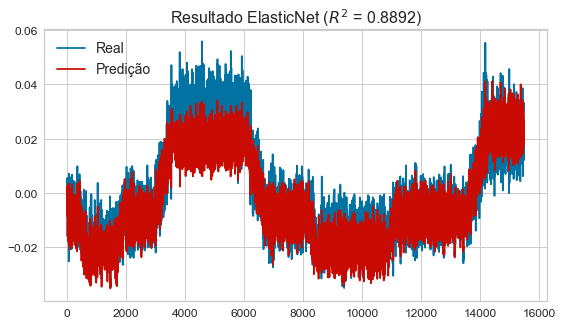

In [11]:
plt.figure(figsize=(9,5))
plt.plot(real,'b',label='Real')
plt.plot(predito,'r',label = 'Predição')
plt.title('Resultado ElasticNet ($R^2$ = 0.8892)',size=16)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.legend(fontsize=14)

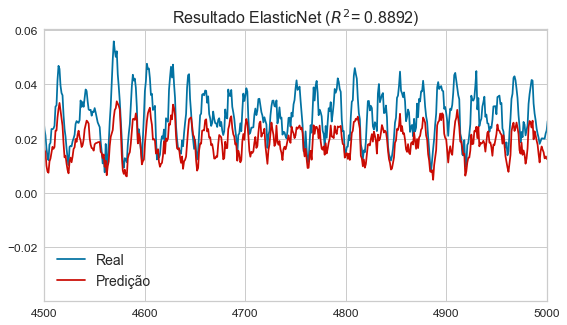

In [12]:
plt.figure(figsize=(9,5))
plt.plot(real,'b',label='Real')
plt.plot(predito,'r',label = 'Predição')
plt.title('Resultado ElasticNet ($R^2$= 0.8892)',size=16)
plt.xlim([4500,5000])
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.legend(fontsize=14)

In [13]:
predito = predito.reshape(predito.shape[0],1)
residuals = real - predito

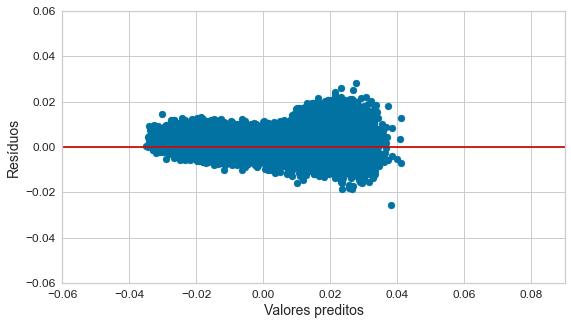

In [14]:
plt.figure(figsize=(9,5))
plt.scatter(predito,residuals)
plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.xlabel('Valores preditos',size=14)
plt.ylabel('Resíduos',size=14)
plt.ylim([-0.06,0.06])
plt.xlim([-0.06,0.09])
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)

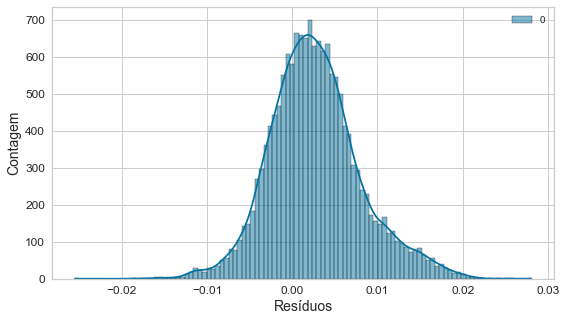

In [15]:
plt.figure(figsize=(9,5))
sns.histplot(data=residuals, kde=True,label=None)
plt.ylabel('Contagem',size=14)
plt.xlabel('Resíduos',size=14)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)

## Suport Vector Machine (SVM)

In [ ]:
from sklearn.svm import SVR

def objective(trial):
    
        
    sv_gamma = trial.suggest_float("gamma", low=0.0001, high=1, step=0.001)
    sv_C= trial.suggest_float("C", low=0.001, high=100,step=0.05)
    sv_epsilon= trial.suggest_float("epsilon", low=0.001, high=1,step=0.01)
    
    #sv_kernel = trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid'])
    
    model = SVR(gamma=sv_gamma,C=sv_C,epsilon=sv_epsilon)
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
#study_svm = optuna.create_study(direction='maximize')

[I 2022-12-04 09:42:46,358] A new study created in memory with name: no-name-6d9d7fea-882b-4fb7-ad6a-fb6303b9fcab


In [ ]:
#study_svm.optimize(objective, n_trials=20,show_progress_bar=True)

#trial = study_svm.best_trial

#print('Accuracy: {}'.format(trial.value))
#print("Best hyperparameters: {}".format(trial.params))

In [ ]:
#joblib.dump(study_svm, "study_SVM.pkl")

### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

def objective(trial):
    
        
    h_n_estimators = trial.suggest_int("n_estimators", low=300, high=1000, step=25)
    h_learning_rate = trial.suggest_float("learning_rate", 0.1, 1)
    h_loss = trial.suggest_categorical("loss", ['linear', 'square', 'exponential'])
    
    model = AdaBoostRegressor(learning_rate=h_learning_rate,
                                       loss=h_loss,
                                       n_estimators=h_n_estimators,
                                       random_state=0)
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
study_ab = optuna.create_study(direction='maximize')

[I 2022-12-04 10:27:50,853] A new study created in memory with name: no-name-a8e1b2ec-bf2f-49dd-81c7-a022899a8687


In [ ]:
study_ab.optimize(objective, n_trials=25)

trial_ab = study_ab.best_trial

print('Accuracy: {}'.format(trial_ab.value))
print("Best hyperparameters: {}".format(trial_ab.params))

In [ ]:
joblib.dump(study_ab, "study_AdaBost.pkl")

['study_AdaBost.pkl']

In [ ]:
optuna.visualization.plot_optimization_history(study_ab)

In [ ]:
optuna.visualization.plot_slice(study_ab)

https://medium.com/analytics-vidhya/xgboost-colsample-by-hyperparameters-explained-6c0bac1bdc1

In [ ]:
import xgboost as xgb

def objective(trial):
    
        
    #x_max_depth = trial.suggest_int("max_depth",2,20)
    #x_learning_rate = trial.suggest_float("learning_rate",0.01,0.1)
    #x_n_estimators = trial.suggest_int("n_estimators", low=50, high=600, step=10)
    #x_colsample_bytree = trial.suggest_float("bytree",0.1,0.9)
    #x_min_child_weight =  trial.suggest_int("min_child_weight",4,12)
    param = {
        'lambda': trial.suggest_loguniform('lambda',low=1e-3,high=5),
        'alpha': trial.suggest_loguniform('alpha', low=1e-3,high=5),
        'colsample_bytree': trial.suggest_float('colsample_bytree',low=0.3,high=1,step=0.1),
        'subsample': trial.suggest_float('subsample',0.1,1,step=0.1),
        'n_estimators': trial.suggest_int('n_estimators', 500, 10000, 25),
        'max_depth': trial.suggest_int('max_depth',2,20,2),
        'random_state': 2020,
        'min_split_loss': trial.suggest_loguniform('min_split_loss',low=1e-3,high=0.1),
        'min_child_weight': trial.suggest_float('min_child_weight',0.1,10,step=0.5),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel',0.3,1,step=0.1),
        'colsample_bynode': trial.suggest_float('colsample_bynode',0.3,1,step=0.1)
    }
    
    model = xgb.XGBRegressor(**param)  
    
    

   
    #model.fit(X_train_scaled,y_train)
    #p=model.predict(X_test_scaled)
    #score= r2_score(y_test,p)
    
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
#study_xgbr= optuna.create_study(direction='maximize')

[I 2022-12-04 11:27:59,105] A new study created in memory with name: no-name-85c9f86f-a017-43e0-905a-4707b8fa343f


In [ ]:
study_xgbr.optimize(objective, n_trials=20)

trial_xgbr= study_xgbr.best_trial

print('Accuracy: {}'.format(trial_xgbr.value))
print("Best hyperparameters: {}".format(trial_xgbr.params))

In [ ]:
joblib.dump(study_xgbr, "study_XGBoost.pkl")

['study_XGBoost.pkl']

In [ ]:
optuna.visualization.plot_optimization_history(study_xgbr)

In [ ]:
optuna.visualization.plot_slice(study_xgbr)

In [ ]:
kajkdjhakakjhkjlkhdl

In [ ]:
study = joblib.load("study_XGBoost.pkl")
print("Best trial until now:")
print(" Value: ", study.best_trial.value)
print(" Params: ",study.best_params)

Best trial until now:
 Value:  0.7740430126296058
 Params:  {'lambda': 0.001530808845481313, 'alpha': 0.02111400159780091, 'colsample_bytree': 0.6000000000000001, 'subsample': 0.7000000000000001, 'n_estimators': 5850, 'max_depth': 10, 'min_split_loss': 0.0027632330369892592, 'min_child_weight': 7.1, 'colsample_bylevel': 0.9000000000000001, 'colsample_bynode': 1.0}


In [ ]:
import xgboost as xgb
mdl = xgb.XGBRegressor(**study.best_params,random_state=2020)
mdl.fit(X_train_scaled,y_train)
p=mdl.predict(X_test_scaled)
score= mean_squared_error(y_test,p)
score_r2 = r2_score(y_test,p)
print("RMSE: ", score)
print("R2: ", score_r2)

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



RMSE:  0.00010128150309338829
R2:  0.7740430126296058


In [ ]:
predito_XGB = np.array(p,dtype=float)
real= np.array(y_test,dtype=float)


In [ ]:
residuals = real - predito

In [ ]:
sns.histplot(data=residuals,label='Resíduos')
plt.legend(fontsize=14)

In [ ]:
sns.boxplot(residuals)

Text(0.5, 1.0, 'Resultado XGBoost $R^2$ = 0.7740')

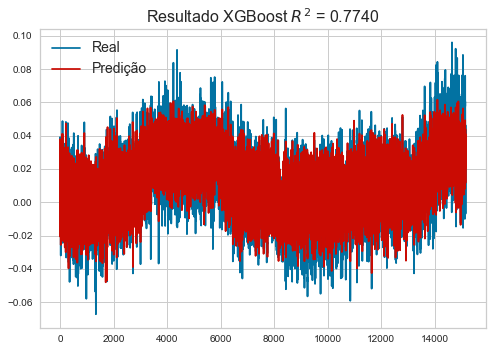

In [ ]:
plt.plot(real,'b',label='Real')
plt.plot(predito_XGB,'r',label = 'Predição')
plt.legend(fontsize=14)
plt.title('Resultado XGBoost $R^2$ = 0.7740',size=16)
#plt.xlim([9000,10000])
#plt.ylim([-0.05,0.1])
#RMSE:  0.0001065447461351567
#R2:  0.7738208762340173

In [ ]:
predicted_XGB = pd.DataFrame(p, columns = ['L/V_FR'])
predicted_XGB.to_csv(r'C:\Users\DELL\Desktop\PG\predito_xgboost.csv', index = False)
y_test.to_csv(r'C:\Users\DELL\Desktop\PG\teste_real.csv', index=False)

# Learning Curve

In [ ]:
plt.figure(figsize=(12,6))

from yellowbrick.model_selection import LearningCurve

# Load a regression dataset

# Instantiate the regression model and visualizer
#model = ElasticNet(**study_en.best_params,random_state=2020)
#visualizer = LearningCurve(model, scoring='r2')

#visualizer.fit(X_train_scaled, y_train)        # Fit the data to the visualizer
#visualizer.show()           # Finalize and render the figure

<Figure size 864x432 with 0 Axes>

# Real intrumantation IRV

In [16]:
X_IRV, y_IRV2 = df[['CC_FR', 'CC_FL', 'CC_BR', 'CC_BL','AT_Y',
'AU_FR','AU_FL','AU_BR','AU_BL','AT_X','AT_Z']], df[['L/V_FL']]
X_train_IRV,X_test_IRV,y_train_IRV,y_test_IRV = create_scaled_dataset(X_IRV,y_IRV2)

In [17]:

def objective(trial):
    
        
    h_alpha = trial.suggest_float("alpha", low=0.0001, high=1, step=0.0001)
    h_l1_ratio= trial.suggest_float("l1_ratio", low=0.0, high=1,step=0.01)
    
    h_selection = trial.suggest_categorical("selection", ['cyclic','random'])
    
    model = ElasticNet(alpha=h_alpha,l1_ratio=h_l1_ratio,
                                       
                                       selection=h_selection,
                                       random_state=0)
    model.fit(X_train_IRV,y_train_IRV)
    p=model.predict(X_test_IRV)
    score= r2_score(y_test_IRV,p)
    return score

    
study_IRV = optuna.create_study(direction='maximize')

[I 2022-12-09 14:36:18,787] A new study created in memory with name: no-name-cb2a353f-215a-49a2-a22c-d6207154f13f


In [18]:
study_IRV.optimize(objective, n_trials=500,show_progress_bar=True)

trial_IRV = study_IRV.best_trial

print('Accuracy: {}'.format(trial_IRV.value))
print("Best hyperparameters: {}".format(trial_IRV.params))

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2022-12-09 14:36:23,173] Trial 0 finished with value: -0.3369294516240158 and parameters: {'alpha': 0.7101000000000001, 'l1_ratio': 0.09, 'selection': 'random'}. Best is trial 0 with value: -0.3369294516240158.
[I 2022-12-09 14:36:23,254] Trial 1 finished with value: -0.3369294516240158 and parameters: {'alpha': 0.602, 'l1_ratio': 0.08, 'selection': 'random'}. Best is trial 0 with value: -0.3369294516240158.
[I 2022-12-09 14:36:23,285] Trial 2 finished with value: -0.3369294516240158 and parameters: {'alpha': 0.9943000000000001, 'l1_ratio': 0.99, 'selection': 'random'}. Best is trial 0 with value: -0.3369294516240158.
[I 2022-12-09 14:36:23,315] Trial 3 finished with value: -0.3369294516240158 and parameters: {'alpha': 0.2206, 'l1_ratio': 0.08, 'selection': 'random'}. Best is trial 0 with value: -0.3369294516240158.
[I 2022-12-09 14:36:23,340] Trial 4 finished with value: -0.3369294516240158 and parameters: {'alpha': 0.383, 'l1_ratio': 0.38, 'selection': 'random'}. Best is trial 0 w

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.263e-01, tolerance: 5.995e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:36:26,074] Trial 45 finished with value: 0.8707631308740351 and parameters: {'alpha': 0.1954, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 37 with value: 0.8875687191540528.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.330e-01, tolerance: 5.995e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:36:27,497] Trial 46 finished with value: 0.8699894240772019 and parameters: {'alpha': 0.2022, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 37 with value: 0.8875687191540528.
[I 2022-12-09 14:36:27,564] Trial 47 finished with value: 0.7309410292616052 and parameters: {'alpha': 0.1937, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 37 with value: 0.8875687191540528.
[I 2022-12-09 14:36:27,612] Trial 48 finished with value: -0.3369294516240158 and parameters: {'alpha': 0.4103, 'l1_ratio': 0.98, 'selection': 'cyclic'}. Best is trial 37 with value: 0.8875687191540528.
[I 2022-12-09 14:36:27,661] Trial 49 finished with value: -0.3369294516240158 and parameters: {'alpha': 0.8567, 'l1_ratio': 0.11, 'selection': 'cyclic'}. Best is trial 37 with value: 0.8875687191540528.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.039e-01, tolerance: 5.995e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:36:28,770] Trial 50 finished with value: 0.861102552011947 and parameters: {'alpha': 0.2786, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 37 with value: 0.8875687191540528.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.858e-01, tolerance: 5.995e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:36:29,971] Trial 51 finished with value: 0.8325680529302565 and parameters: {'alpha': 0.5103, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 37 with value: 0.8875687191540528.
[I 2022-12-09 14:36:30,017] Trial 52 finished with value: -0.10200454830973538 and parameters: {'alpha': 0.2611, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 37 with value: 0.8875687191540528.
[I 2022-12-09 14:36:30,065] Trial 53 finished with value: -0.3369294516240158 and parameters: {'alpha': 0.2964, 'l1_ratio': 0.09, 'selection': 'cyclic'}. Best is trial 37 with value: 0.8875687191540528.
[I 2022-12-09 14:36:30,108] Trial 54 finished with value: -0.3369294516240158 and parameters: {'alpha': 0.2038, 'l1_ratio': 0.16, 'selection': 'cyclic'}. Best is trial 37 with value: 0.8875687191540528.
[I 2022-12-09 14:36:30,152] Trial 55 finished with value: 0.14848314361182435 and parameters: {'alpha': 0.1538, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 37 with value: 0.8875

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.570e-01, tolerance: 5.995e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:36:31,440] Trial 56 finished with value: 0.8536475061685683 and parameters: {'alpha': 0.3408, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 37 with value: 0.8875687191540528.
[I 2022-12-09 14:36:31,492] Trial 57 finished with value: -0.07876534522577727 and parameters: {'alpha': 0.039900000000000005, 'l1_ratio': 0.2, 'selection': 'cyclic'}. Best is trial 37 with value: 0.8875687191540528.
[I 2022-12-09 14:36:31,541] Trial 58 finished with value: -0.3369294516240158 and parameters: {'alpha': 0.3792, 'l1_ratio': 0.3, 'selection': 'cyclic'}. Best is trial 37 with value: 0.8875687191540528.
[I 2022-12-09 14:36:31,578] Trial 59 finished with value: -0.3369294516240158 and parameters: {'alpha': 0.4733, 'l1_ratio': 0.1, 'selection': 'cyclic'}. Best is trial 37 with value: 0.8875687191540528.
[I 2022-12-09 14:36:31,635] Trial 60 finished with value: -0.3369294516240158 and parameters: {'alpha': 0.6073000000000001, 'l1_ratio': 0.05, 'selection': 'cyclic'}. Best is tria

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.682e-01, tolerance: 5.995e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:36:32,769] Trial 61 finished with value: 0.8519826926687508 and parameters: {'alpha': 0.3545, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 37 with value: 0.8875687191540528.
[I 2022-12-09 14:36:32,808] Trial 62 finished with value: -0.3369294516240158 and parameters: {'alpha': 0.2227, 'l1_ratio': 0.14, 'selection': 'cyclic'}. Best is trial 37 with value: 0.8875687191540528.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.395e-01, tolerance: 5.995e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:36:34,037] Trial 63 finished with value: 0.8561719709254975 and parameters: {'alpha': 0.3199, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 37 with value: 0.8875687191540528.
[I 2022-12-09 14:36:34,086] Trial 64 finished with value: -0.3369294516240158 and parameters: {'alpha': 0.2849, 'l1_ratio': 0.08, 'selection': 'cyclic'}. Best is trial 37 with value: 0.8875687191540528.
[I 2022-12-09 14:36:34,136] Trial 65 finished with value: 0.5350277932414995 and parameters: {'alpha': 0.12739999999999999, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 37 with value: 0.8875687191540528.
[I 2022-12-09 14:36:34,180] Trial 66 finished with value: -0.3369294516240158 and parameters: {'alpha': 0.1674, 'l1_ratio': 0.8200000000000001, 'selection': 'cyclic'}. Best is trial 37 with value: 0.8875687191540528.
[I 2022-12-09 14:36:34,224] Trial 67 finished with value: -0.3369294516240158 and parameters: {'alpha': 0.2414, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is tr

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.873e-01, tolerance: 5.995e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:36:36,473] Trial 74 finished with value: 0.8843130228073321 and parameters: {'alpha': 0.06820000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 70 with value: 0.8879632539439887.
[I 2022-12-09 14:36:36,516] Trial 75 finished with value: -0.3369294516240158 and parameters: {'alpha': 0.0699, 'l1_ratio': 0.18, 'selection': 'random'}. Best is trial 70 with value: 0.8879632539439887.
[I 2022-12-09 14:36:36,561] Trial 76 finished with value: -0.3369294516240158 and parameters: {'alpha': 0.09340000000000001, 'l1_ratio': 0.14, 'selection': 'cyclic'}. Best is trial 70 with value: 0.8879632539439887.
[I 2022-12-09 14:36:36,646] Trial 77 finished with value: 0.8774916193131523 and parameters: {'alpha': 0.005, 'l1_ratio': 0.07, 'selection': 'random'}. Best is trial 70 with value: 0.8879632539439887.
[I 2022-12-09 14:36:36,740] Trial 78 finished with value: 0.7137615520899245 and parameters: {'alpha': 0.0415, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.822e-01, tolerance: 5.995e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:36:48,007] Trial 180 finished with value: 0.8138442317346324 and parameters: {'alpha': 0.6556000000000001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 126 with value: 0.8901284927886272.
[I 2022-12-09 14:36:48,180] Trial 181 finished with value: 0.8880817888112031 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.11, 'selection': 'random'}. Best is trial 126 with value: 0.8901284927886272.
[I 2022-12-09 14:36:48,256] Trial 182 finished with value: 0.889092297334116 and parameters: {'alpha': 0.0011, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 126 with value: 0.8901284927886272.
[I 2022-12-09 14:36:48,336] Trial 183 finished with value: 0.8040112879807259 and parameters: {'alpha': 0.0171, 'l1_ratio': 0.09, 'selection': 'random'}. Best is trial 126 with value: 0.8901284927886272.
[I 2022-12-09 14:36:48,393] Trial 184 finished with value: 0.8507854482939945 and parameters: {'alpha': 0.0207, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 126 wi

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.255e-01, tolerance: 5.995e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:36:54,819] Trial 265 finished with value: 0.887835866083158 and parameters: {'alpha': 0.0208, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 126 with value: 0.8901284927886272.
[I 2022-12-09 14:36:54,964] Trial 266 finished with value: 0.8886777439917457 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 126 with value: 0.8901284927886272.
[I 2022-12-09 14:36:55,029] Trial 267 finished with value: 0.8398093126878985 and parameters: {'alpha': 0.046200000000000005, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 126 with value: 0.8901284927886272.
[I 2022-12-09 14:36:55,102] Trial 268 finished with value: 0.8426378069713674 and parameters: {'alpha': 0.0193, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 126 with value: 0.8901284927886272.
[I 2022-12-09 14:36:55,155] Trial 269 finished with value: 0.5491700973062865 and parameters: {'alpha': 0.03900000000000001, 'l1_ratio': 0.1, 'selection': '

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.262e-01, tolerance: 5.995e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:36:57,614] Trial 294 finished with value: 0.8878186262239812 and parameters: {'alpha': 0.0213, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 126 with value: 0.8901284927886272.
[I 2022-12-09 14:36:57,685] Trial 295 finished with value: 0.452351686982143 and parameters: {'alpha': 0.07500000000000001, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 126 with value: 0.8901284927886272.
[I 2022-12-09 14:36:57,747] Trial 296 finished with value: 0.7768641505160341 and parameters: {'alpha': 0.04510000000000001, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 126 with value: 0.8901284927886272.
[I 2022-12-09 14:36:57,840] Trial 297 finished with value: 0.8894336363977859 and parameters: {'alpha': 0.0008, 'l1_ratio': 0.07, 'selection': 'random'}. Best is trial 126 with value: 0.8901284927886272.
[I 2022-12-09 14:36:57,910] Trial 298 finished with value: 0.820322050295638 and parameters: {'alpha': 0.018600000000000002, 'l1_ratio': 0.07, 'selection': 'ran

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.248e-01, tolerance: 5.995e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:36:59,897] Trial 315 finished with value: 0.8878521797093336 and parameters: {'alpha': 0.020300000000000002, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 126 with value: 0.8901284927886272.
[I 2022-12-09 14:36:59,955] Trial 316 finished with value: 0.8417260015912115 and parameters: {'alpha': 0.0014000000000000002, 'l1_ratio': 0.74, 'selection': 'cyclic'}. Best is trial 126 with value: 0.8901284927886272.
[I 2022-12-09 14:37:00,127] Trial 317 finished with value: 0.889911963601235 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.08, 'selection': 'random'}. Best is trial 126 with value: 0.8901284927886272.
[I 2022-12-09 14:37:00,196] Trial 318 finished with value: 0.5261176265667128 and parameters: {'alpha': 0.037000000000000005, 'l1_ratio': 0.11, 'selection': 'random'}. Best is trial 126 with value: 0.8901284927886272.
[I 2022-12-09 14:37:00,253] Trial 319 finished with value: -0.11698657493905595 and parameters: {'alpha': 0.0585, 'l1_ratio': 0.14, 'selection'

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.692e-01, tolerance: 5.995e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:37:05,239] Trial 372 finished with value: 0.8856221084090977 and parameters: {'alpha': 0.053700000000000005, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 126 with value: 0.8901284927886272.
[I 2022-12-09 14:37:05,388] Trial 373 finished with value: 0.8893364728854306 and parameters: {'alpha': 0.0005, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 126 with value: 0.8901284927886272.
[I 2022-12-09 14:37:05,444] Trial 374 finished with value: 0.8203756583864403 and parameters: {'alpha': 0.03150000000000001, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 126 with value: 0.8901284927886272.
[I 2022-12-09 14:37:05,525] Trial 375 finished with value: 0.7980278114577348 and parameters: {'alpha': 0.0727, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 126 with value: 0.8901284927886272.
[I 2022-12-09 14:37:05,590] Trial 376 finished with value: 0.8443258328899569 and parameters: {'alpha': 0.0188, 'l1_ratio': 0.05, 'selection': 'random'}. Best

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.369e-01, tolerance: 5.995e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:37:06,602] Trial 379 finished with value: 0.887451484256389 and parameters: {'alpha': 0.0291, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 126 with value: 0.8901284927886272.
[I 2022-12-09 14:37:06,677] Trial 380 finished with value: 0.8335983881951927 and parameters: {'alpha': 0.0184, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 126 with value: 0.8901284927886272.
[I 2022-12-09 14:37:06,756] Trial 381 finished with value: 0.8130479269365911 and parameters: {'alpha': 0.044300000000000006, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 126 with value: 0.8901284927886272.
[I 2022-12-09 14:37:06,802] Trial 382 finished with value: -0.3369294516240158 and parameters: {'alpha': 0.2422, 'l1_ratio': 0.07, 'selection': 'random'}. Best is trial 126 with value: 0.8901284927886272.
[I 2022-12-09 14:37:06,884] Trial 383 finished with value: 0.8459900263994906 and parameters: {'alpha': 0.0183, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 126

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.435e-01, tolerance: 5.995e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:37:08,187] Trial 390 finished with value: 0.8871496162996991 and parameters: {'alpha': 0.034, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 126 with value: 0.8901284927886272.
[I 2022-12-09 14:37:08,319] Trial 391 finished with value: 0.888327865505348 and parameters: {'alpha': 0.0007000000000000001, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 126 with value: 0.8901284927886272.
[I 2022-12-09 14:37:08,395] Trial 392 finished with value: 0.8494975905226341 and parameters: {'alpha': 0.0212, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 126 with value: 0.8901284927886272.
[I 2022-12-09 14:37:08,463] Trial 393 finished with value: 0.8303094245535312 and parameters: {'alpha': 0.0524, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 126 with value: 0.8901284927886272.
[I 2022-12-09 14:37:08,525] Trial 394 finished with value: -0.08023868325045491 and parameters: {'alpha': 0.08800000000000001, 'l1_ratio': 0.09, 'selection': 'random'}. Bes

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.230e-01, tolerance: 5.995e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:37:09,921] Trial 402 finished with value: 0.8878900001286577 and parameters: {'alpha': 0.019, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 126 with value: 0.8901284927886272.
[I 2022-12-09 14:37:09,973] Trial 403 finished with value: -0.3369294516240158 and parameters: {'alpha': 0.06470000000000001, 'l1_ratio': 0.32, 'selection': 'random'}. Best is trial 126 with value: 0.8901284927886272.
[I 2022-12-09 14:37:10,046] Trial 404 finished with value: 0.7956311758734232 and parameters: {'alpha': 0.0205, 'l1_ratio': 0.08, 'selection': 'random'}. Best is trial 126 with value: 0.8901284927886272.
[I 2022-12-09 14:37:10,178] Trial 405 finished with value: 0.8892425315782455 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 126 with value: 0.8901284927886272.
[I 2022-12-09 14:37:10,259] Trial 406 finished with value: 0.8153048829954506 and parameters: {'alpha': 0.043300000000000005, 'l1_ratio': 0.03, 'selection': 'random'}. Best

In [19]:
study_IRV.best_trial

FrozenTrial(number=126, values=[0.8901284927886272], datetime_start=datetime.datetime(2022, 12, 9, 14, 36, 40, 705409), datetime_complete=datetime.datetime(2022, 12, 9, 14, 36, 40, 895898), params={'alpha': 0.0005, 'l1_ratio': 0.07, 'selection': 'random'}, distributions={'alpha': FloatDistribution(high=1.0, log=False, low=0.0001, step=0.0001), 'l1_ratio': FloatDistribution(high=1.0, log=False, low=0.0, step=0.01), 'selection': CategoricalDistribution(choices=('cyclic', 'random'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=126, state=TrialState.COMPLETE, value=None)

In [20]:
mdl_IRV = ElasticNet(**study_IRV.best_params,random_state=2020)
mdl_IRV.fit(X_train_IRV,y_train_IRV)
p=mdl_IRV.predict(X_test_IRV)
score_IRV = mean_squared_error(y_test_IRV,p)
score_r2_IRV = r2_score(y_test_IRV,p)
print("RMSE: ", score_IRV)
print("R2: ", score_r2_IRV)
predito_IRV = np.array(p,dtype=float)
real_IRV= np.array(y_test_IRV,dtype=float)

RMSE:  3.5907550493774534e-05
R2:  0.8901109701881049


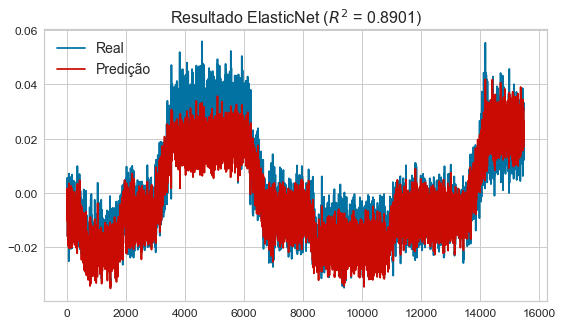

In [21]:
plt.figure(figsize=(9,5))
plt.plot(real_IRV,'b',label='Real')
plt.plot(predito_IRV,'r',label = 'Predição')
plt.title('Resultado ElasticNet ($R^2$ = 0.8901)',size=16)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.legend(fontsize=14)

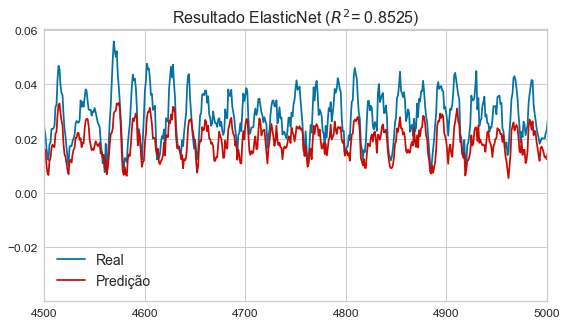

In [22]:
plt.figure(figsize=(9,5))
plt.plot(real_IRV,'b',label='Real')
plt.plot(predito_IRV,'r',label = 'Predição')
plt.title('Resultado ElasticNet ($R^2$= 0.8525)',size=16)
plt.xlim([4500,5000])
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.legend(fontsize=14)

In [23]:
predito_IRV = predito_IRV.reshape(predito_IRV.shape[0],1)
residuals_IRV = real_IRV - predito_IRV

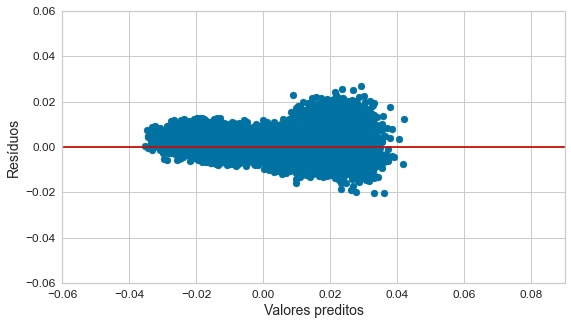

In [24]:
plt.figure(figsize=(9,5))
plt.scatter(predito_IRV,residuals_IRV)
plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.xlabel('Valores preditos',size=14)
plt.ylabel('Resíduos',size=14)
plt.ylim([-0.06,0.06])
plt.xlim([-0.06,0.09])
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)

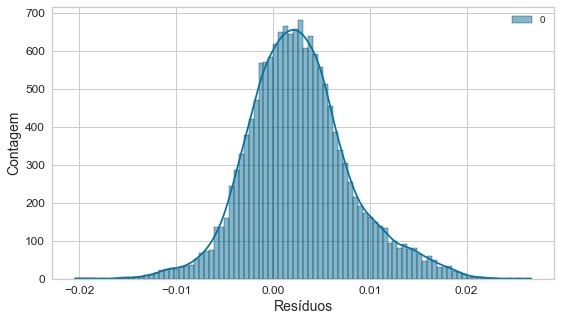

In [25]:
plt.figure(figsize=(9,5))
sns.histplot(data=residuals_IRV, kde=True,label=None)
plt.ylabel('Contagem',size=14)
plt.xlabel('Resíduos',size=14)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)